In [1]:
# Common, File Based, and Math Imports
import pandas as pd
import numpy as np
np.fft.restore_all()
import collections
import os
from os.path import isdir, join
from pathlib import Path
from subprocess import check_output
import sys
import math
import pickle
from glob import glob
import random
from random import sample
import json
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numpy.lib.stride_tricks import as_strided
from tqdm import tqdm

# Audio processing
from scipy import signal
from scipy.fftpack import dct
import soundfile
import json
from python_speech_features import mfcc
import scipy.io.wavfile as wav
from scipy.fftpack import fft

# Neural Network
import keras
from keras.utils.generic_utils import get_custom_objects
from keras import backend as K
from keras import regularizers, callbacks
from keras.constraints import max_norm
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Lambda, Dense, Dropout, Flatten, Embedding, merge, Activation, GRUCell, LSTMCell,SimpleRNNCell
from keras.layers import Convolution2D, MaxPooling2D, Convolution1D, Conv1D, SimpleRNN, GRU, LSTM, CuDNNLSTM, CuDNNGRU, Conv2D
from keras.layers.advanced_activations import LeakyReLU, PReLU, ThresholdedReLU, ELU
from keras.layers import LeakyReLU, PReLU, ThresholdedReLU, ELU
from keras.layers import BatchNormalization, TimeDistributed, Bidirectional
from keras.layers import activations, Wrapper
from keras.regularizers import l2
from keras.optimizers import Adam, SGD, RMSprop, Adagrad, Adadelta, Adamax, Nadam
from keras.callbacks import ModelCheckpoint 
from keras.utils import np_utils
from keras import constraints, initializers, regularizers
from keras.engine.topology import Layer
import keras.losses
from keras.backend.tensorflow_backend import set_session
from keras.engine import InputSpec
import tensorflow as tf 
from tensorflow.python.framework import graph_io
from tensorflow.python.tools import freeze_graph
from tensorflow.core.protobuf import saver_pb2
from tensorflow.python.training import saver as saver_lib

# Model metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Visualization
import IPython.display as ipd
from IPython.display import Markdown, display, Audio
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls

found and restoring...
found and restoring...
found and restoring...
found and restoring...
found and restoring...
found and restoring...
found and restoring...
found and restoring...
found and restoring...
found and restoring...
found and restoring...
found and restoring...
found and restoring...
found and restoring...


/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# DATA PROCESSING FUNCTION

In [2]:
train_corpus = pd.read_json('train_corpus.json', lines=True)
valid_corpus = pd.read_json('valid_corpus.json', lines=True)
test_corpus = pd.read_json('test_corpus.json', lines=True)
train_duration_mean = train_corpus.duration.mean()
valid_duration_mean = valid_corpus.duration.mean()
test_duration_mean = test_corpus.duration.mean()
print('Train Set Duration Mean:', train_duration_mean)
print('Valid Set Duration Mean:', valid_duration_mean)
print('Test Set Duration Mean:', test_duration_mean)

Train Set Duration Mean: 12.781847165282612
Valid Set Duration Mean: 7.840140538290793
Test Set Duration Mean: 8.214013597328261


In [3]:
train_duration_median = train_corpus.duration.median()
valid_duration_median = valid_corpus.duration.median()
test_duration_median = test_corpus.duration.median()
print('Train Set Duration Median:', train_duration_median)
print('Valid Set Duration Median:', valid_duration_median)
print('Test Set Duration Median:', test_duration_median)

Train Set Duration Median: 14.025
Valid Set Duration Median: 6.425
Test Set Duration Median: 6.3575


In [4]:
def plot_raw_audio(sample_rate, samples):
    # Plot the raw audio signal
    time = np.arange(0, float(samples.shape[0]), 1) / sample_rate
    fig = plt.figure(figsize=(12,5))
    ax = fig.add_subplot(111)
    ax.plot(time, samples, linewidth=1, alpha=0.7, color='#76b900')
    plt.title('Raw Audio Signal')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.show()
    
def plot_mfcc_feature(mfcc_feature):
    # Plot a normalized MFCC feature
    fig = plt.figure(figsize=(12,5))
    ax = fig.add_subplot(111)
    im = ax.imshow(mfcc_feature, cmap=plt.cm.viridis, aspect='auto')
    plt.title('Normalized MFCC')
    plt.ylabel('Time')
    plt.xlabel('MFCC Coefficient')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    ax.set_xticks(np.arange(0, 13, 2), minor=False);
    plt.show()

In [5]:
# Mapping each character that could be spoken at each time step
char_map_str = """
' 0
<SPACE> 1
a 2
b 3
c 4
d 5
e 6
f 7
g 8
h 9
i 10
j 11
k 12
l 13
m 14
n 15
o 16
p 17
q 18
r 19
s 20
t 21
u 22
v 23
w 24
x 25
y 26
z 27
"""
# This leaves "blank" character mapped to number 28

char_map = {}
index_map = {}
for line in char_map_str.strip().split('\n'):
    ch, index = line.split()
    char_map[ch] = int(index)
    index_map[int(index)+1] = ch
index_map[2] = ' '

# Function for converting text to an integer sequence
def text_to_int_seq(text):
    int_sequence = []
    for c in text:
        if c == ' ':
            ch = char_map['<SPACE>']
        else:
            ch = char_map[c]
        int_sequence.append(ch)
    return int_sequence

# Function for converting an integer sequence to text
def int_seq_to_text(int_sequence):
    text = []
    for c in int_sequence:
        ch = index_map[c]
        text.append(ch)
    return text
        

In [6]:
max_duration=10.0
mfcc_dim=13
minibatch_size=16
rng= random.Random(95)
feats_mean = np.zeros((13,))
feats_std = np.ones((13,))
cur_train_index = 0
cur_valid_index=0
cur_test_index =0

In [7]:
def load_data_from_file(desc_file, partition):
    # Get metadata from json corpus
        audio_paths, durations, texts = [], [], []
        with open(desc_file) as json_line_file:
            for line_num, json_line in enumerate(json_line_file):
                    spec = json.loads(json_line)
                    if float(spec['duration']) > max_duration:
                        continue
                    audio_paths.append(spec['key'])
                    durations.append(float(spec['duration']))
                    texts.append(spec['text'])
                
        if partition == 'train':
            train_audio_paths = audio_paths
            train_durations = durations
            train_texts = texts
            return train_audio_paths,train_durations,train_texts
        elif partition == 'validation':
            valid_audio_paths = audio_paths
            valid_durations = durations
            valid_texts = texts
            return valid_audio_paths,valid_durations,valid_texts
        elif partition == 'test':
            test_audio_paths = audio_paths
            test_durations = durations
            test_texts = texts
            return test_audio_paths,test_durations,test_texts

In [8]:
def featurize(audio_clip):
    # Create features from data - mfcc
        (rate, sig) = wav.read(audio_clip)
        return mfcc(sig, rate, numcep = mfcc_dim)

def normalize(feature, eps=1e-14):
    # Scale the data to improve neural network performance and reduce the size of the gradients
    return (feature - feats_mean) / (feats_std + eps)

In [9]:
def fit_train(k_samples=100):
    # Estimate descriptive stats for training set based on sample of 100 instances
    k_samples = min(k_samples, len(train_audio_paths))
    samples = rng.sample(train_audio_paths, k_samples)
    feats = [featurize(s) for s in samples]
    feats = np.vstack(feats)
    global feats_mean
    global feats_std
    feats_mean = np.mean(feats, axis=0)
    print(feats_mean)
    feats_std = np.std(feats, axis=0)
    print(feats_std)
    
def load_train_data(desc_file='train_corpus.json'):
    train_audio_paths,train_duration,train_texts = load_data_from_file(desc_file, 'train')
    return train_audio_paths,train_duration,train_texts

def load_validation_data(desc_file='valid_corpus.json'):
    valid_audio_paths,valid_durations,valid_texts = load_data_from_file(desc_file, 'validation')
    return valid_audio_paths,valid_durations,valid_texts

def load_test_data(desc_file='test_corpus.json'):
    test_audio_paths,test_durations,test_texts = load_data_from_file(desc_file, 'test')
    return test_audio_paths,test_durations,test_texts

train_audio_paths,train_duration,train_texts = load_train_data()
valid_audio_paths,valid_durations,valid_texts = load_validation_data()
test_audio_paths,test_durations,test_texts = load_test_data()

fit_train()

[15.70873169 -6.56353668 -6.08320134  4.53778827 -9.10611142 -6.11329055
 -9.35815996 -4.17870807 -0.94557164 -2.1991181  -2.39670999 -3.86390968
 -2.76450215]
[ 4.17292603 17.24005284 15.48734509 16.6599952  16.35737414 17.0542625
 17.04751052 15.20767253 14.39424324 13.56772844 12.9005077  11.99311185
 10.85321116]


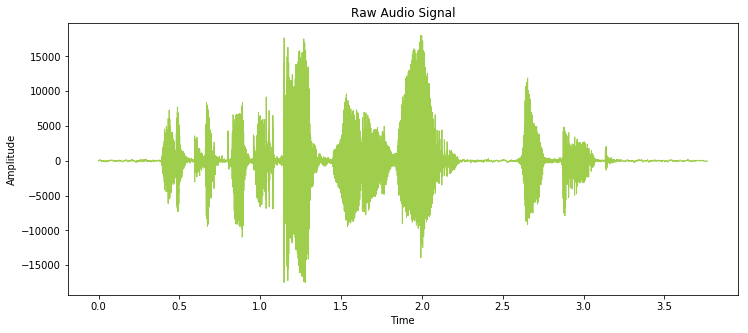

**Audio File Transcription** : she'd keep people off very well i think

[[ 8.43939539  3.29477285  5.94168371 ...  0.3002601   2.11430121
   8.55897817]
 [ 7.79075849 11.72670345  5.22931234 ...  2.38007151  2.69360331
   6.06955986]
 [ 8.13375684 12.78524324  7.10212295 ... -1.2226872   6.684121
   8.19885821]
 ...
 [ 7.24061299 10.80692997  8.00980089 ... 13.38264928  1.56279715
   1.12364386]
 [ 7.17779086 10.71739879  8.50266164 ... 12.91816245  1.45730168
   2.72655448]
 [ 7.49584486 10.44133942  5.76460723 ... 13.49619806  8.50918883
   1.60267167]]


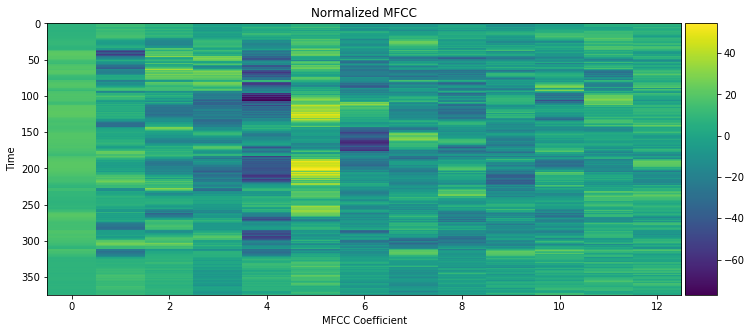

[[-1.74202376  0.57182595  0.77643295 ...  0.20905922  0.49847037
   1.04332996]
 [-1.89746311  1.06091555  0.73043595 ...  0.37027857  0.54677327
   0.81395836]
 [-1.81526698  1.12231558  0.85136117 ...  0.09100594  0.87950741
   1.010149  ]
 ...
 [-2.02929998  1.00756458  0.90996889 ...  1.22315801  0.4524853
   0.35824844]
 [-2.04435467  1.00237138  0.94179234 ...  1.18715269  0.44368896
   0.50593843]
 [-1.96813621  0.9863587   0.76499933 ...  1.23195989  1.03168374
   0.40238541]]


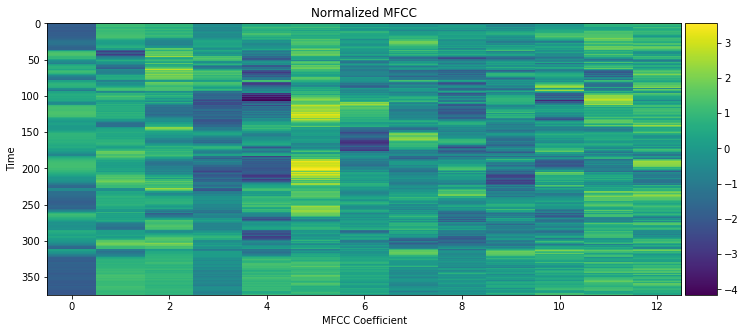

In [10]:
mfcc_1 = featurize(train_audio_paths[0])
sample_rate, samples = wav.read(train_audio_paths[0])
plot_raw_audio(sample_rate, samples)
display(Markdown('**Audio File Transcription** : ' + str(train_texts[0])))
Audio(train_audio_paths[0])
print(mfcc_1)
plot_mfcc_feature(mfcc_1)
mfcc_1_norm = normalize(mfcc_1)
print(mfcc_1_norm)
plot_mfcc_feature(mfcc_1_norm)

In [11]:
def get_batch(partition):
    # Obtain a batch of audio files
        if partition == 'train':
            audio_paths = train_audio_paths
            cur_index = cur_train_index
            texts = train_texts
        elif partition == 'valid':
            audio_paths = valid_audio_paths
            cur_index = cur_valid_index
            texts = valid_texts
        elif partition == 'test':
            audio_paths = test_audio_paths
            cur_index = test_valid_index
            texts = test_texts
        
        features = [normalize(featurize(a)) for a in 
            audio_paths[cur_index:cur_index+minibatch_size]]

        # Calculate size
        max_length = max([features[i].shape[0] 
            for i in range(0, minibatch_size)])
        max_string_length = max([len(texts[cur_index+i]) 
            for i in range(0, minibatch_size)])
        
        # Initialize arrays
        X_data = np.zeros([minibatch_size, max_length, mfcc_dim])
        #print(X_data.shape)
        labels = np.ones([minibatch_size, max_string_length]) * 28
        input_length = np.zeros([minibatch_size, 1])
        label_length = np.zeros([minibatch_size, 1])
        
        for i in range(0, minibatch_size):
            # Calculate input_length
            feat = features[i]
            input_length[i] = feat.shape[0]
            X_data[i, :feat.shape[0], :] = feat

            # Calculate label_length
            label = np.array(text_to_int_seq(texts[cur_index+i])) 
            labels[i, :len(label)] = label
            label_length[i] = len(label)

        # Output arrays
        outputs = {'ctc': np.zeros([minibatch_size])}
        inputs = {'the_input': X_data, 
                  'the_labels': labels, 
                  'input_length': input_length, 
                  'label_length': label_length 
                 }
        return (inputs, outputs)

def next_train():
    # Get a batch of training data
    while True:
        ret = get_batch('train')
        global cur_train_index 
        cur_train_index += minibatch_size
        if cur_train_index >= len(train_texts) - minibatch_size:
            cur_train_index = 0
        #print(ret)
        yield ret    

def next_valid():
    # Get a batch of validation data
    while True:
        ret = get_batch('valid')
        global cur_valid_index
        cur_valid_index += minibatch_size
        if cur_valid_index >= len(valid_texts) - minibatch_size:
            cur_valid_index = 0
        yield ret

def next_test():
    # Get a batch of testing data
    while True:
        ret = get_batch('test')
        global cur_test_index
        cur_test_index += minibatch_size
        if cur_test_index >= len(test_texts) - minibatch_size:
            cur_test_index = 0
        yield ret
        
    

In [12]:
if not os.path.exists('results'):
        os.makedirs('results')

In [13]:
# Custom CTC loss function (discussed below)
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

def add_ctc_loss(input_to_softmax):
    the_labels = Input(name='the_labels', shape=(None,), dtype='float32')
    input_lengths = Input(name='input_length', shape=(1,), dtype='int64')
    label_lengths = Input(name='label_length', shape=(1,), dtype='int64')
    output_lengths = Lambda(input_to_softmax.output_length)(input_lengths)
    # CTC loss is implemented in a lambda layer
    loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')(
        [input_to_softmax.output, the_labels, output_lengths, label_lengths])
    model = Model(
        inputs=[input_to_softmax.input, the_labels, input_lengths, label_lengths], 
        outputs=loss_out)
    return model

def cnn_output_length(input_length, filter_size, border_mode, stride,
                       dilation=1):
# Compute the length of cnn output seq after 1D convolution across time
    if input_length is None:
        return None
    assert border_mode in {'same', 'valid', 'causal'}
    dilated_filter_size = filter_size + (filter_size - 1) * (dilation - 1)
    if border_mode == 'same':
        output_length = input_length
    elif border_mode == 'valid':
        output_length = input_length - dilated_filter_size + 1
    elif border_mode == 'causal':
        output_length = input_length
    return (output_length + stride - 1) // stride

In [14]:
# Word Error Rate
def wer_calc(ref, pred):
    # Calcualte word error rate
    d = np.zeros((len(ref) + 1) * (len(pred) + 1), dtype=np.uint16)
    d = d.reshape((len(ref) + 1, len(pred) + 1))
    for i in range(len(ref) + 1):
        for j in range(len(pred) + 1):
            if i == 0:
                d[0][j] = j
            elif j == 0:
                d[i][0] = i

    for i in range(1, len(ref) + 1):
        for j in range(1, len(pred) + 1):
            if ref[i - 1] == pred[j - 1]:
                d[i][j] = d[i - 1][j - 1]
            else:
                substitution = d[i - 1][j - 1] + 1
                insertion = d[i][j - 1] + 1
                deletion = d[i - 1][j] + 1
                d[i][j] = min(substitution, insertion, deletion)
    result = float(d[len(ref)][len(pred)]) / len(ref) * 100
    return result

In [15]:
num_train_examples=len(train_audio_paths)
steps_per_epoch = num_train_examples/16

In [16]:
num_valid_samples = len(valid_audio_paths) 
validation_steps = num_valid_samples//16

# RNN GRU 1 layer

## Adding Layers and Training Model

In [ ]:
for i in range(1):
    input_data = Input(name='the_input', shape=(None, 13))
    
    simp_rnn = GRU(29, return_sequences=True, 
                 implementation=2, name='rnn')(input_data)
    
    y_pred = Activation('softmax', name='softmax')(simp_rnn)
    
    model_rnn_simple = Model(inputs=input_data, outputs=y_pred)
    
    model_rnn_simple.output_length = lambda x: x
    
    model_rnn_simple.summary()
    
    optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False, clipnorm=1, clipvalue=.5)
    # Add custom CTC loss function to the nn
    
    model_1 = add_ctc_loss(model_rnn_simple)
    # Dummy lambda function for loss since CTC loss is implemented above
    
    model_1.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)
# Callbacks
    
    checkpointer = ModelCheckpoint(filepath='results/model_rnn_simple.h5', verbose=0)
    
    stopper = callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')
    
    terminator = callbacks.TerminateOnNaN()
# training     
    mod_1 = model_1.fit_generator(generator=next_train(), steps_per_epoch=steps_per_epoch,
        epochs=10, validation_data=next_valid(), validation_steps=validation_steps,
        callbacks=[checkpointer,terminator, stopper], verbose=1)

## Getting Predictions

In [ ]:
transcription = test_texts[10]
audio_path = test_audio_paths[10]
data_point = featurize(audio_path)
print(data_point.shape)
model_rnn_simple.load_weights('./results/model_rnn_simple.h5')

        
prediction = model_rnn_simple.predict(np.expand_dims(data_point,axis=0),)
output_length = [model_rnn_simple.output_length(data_point.shape[0])]
pred_ints = (K.eval(K.ctc_decode(
                prediction, output_length)[0][0])+1).flatten().tolist()

print(prediction.shape)
print(prediction)
print(output_length)

print(pred_ints)
pred = ''.join(int_seq_to_text(pred_ints))
    # Display ground truth transcription and predicted transcripted.
%time
print('True transcription:\n' + '\n' + transcription)
print('Predicted transcription:\n' + '\n' + pred)

## Performane

In [ ]:
# Error rate
error_rate_gru_1 = wer_calc(transcription,pred)
print(error_rate_gru_1)
accuracy_gru_1 = 100 - error_rate_gru_1
print(accuracy_gru_1)

# RNN GRU 2 layers

## Adding Layers and Training Model

In [ ]:
for i in range(5):
    input_data = Input(name='the_input', shape=(None, 13))
    
    simp_rnn = GRU(256, return_sequences=True, 
                 implementation=2, name='rnn')(input_data)
    simp_rnn = GRU(128, return_sequences=True, 
                 implementation=2, name='rnn_1')(simp_rnn)
    dense = Dense(29)(simp_rnn)
    y_pred = Activation('softmax', name='softmax')(dense)
    
    model_rnn_simple_2l = Model(inputs=input_data, outputs=y_pred)
    
    model_rnn_simple_2l.output_length = lambda x: x
    
    model_rnn_simple_2l.summary()
    
    optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False, clipnorm=1, clipvalue=.5)
    # Add custom CTC loss function to the nn
    
    model_2 = add_ctc_loss(model_rnn_simple_2l)
    # Dummy lambda function for loss since CTC loss is implemented above
    
    model_2.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)
# Callbacks
    
    checkpointer = ModelCheckpoint(filepath='results/model_rnn_simple_2l.h5', verbose=0)
    
    stopper = callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')
    
    terminator = callbacks.TerminateOnNaN()
# training     
    mod_2 = model_2.fit_generator(generator=next_train(), steps_per_epoch=steps_per_epoch,
        epochs=10, validation_data=next_valid(), validation_steps=validation_steps,
        callbacks=[checkpointer,terminator, stopper], verbose=1)

## Getting Predictions

In [ ]:
transcription = test_texts[10]
audio_path = test_audio_paths[10]
data_point = featurize(audio_path)
print(data_point.shape)
model_rnn_simple.load_weights('./results/model_rnn_simple_2l.h5')

        
prediction = model_rnn_simple.predict(np.expand_dims(data_point,axis=0),)
output_length = [model_rnn_simple.output_length(data_point.shape[0])]
pred_ints = (K.eval(K.ctc_decode(
                prediction, output_length)[0][0])+1).flatten().tolist()
print(prediction.shape)
print(prediction)
print(output_length)

print(pred_ints)
pred = ''.join(int_seq_to_text(pred_ints))
    # Display ground truth transcription and predicted transcripted.
%time
print('True transcription:\n' + '\n' + transcription)
print('Predicted transcription:\n' + '\n' + pred)

## Performane

In [ ]:
# Error rate
error_rate_gru_2 = wer_calc(transcription,pred)
print(error_rate_gru_2)
accuracy_gru_2 = 100 - error_rate_gru_2
print(accuracy_gru_2)

# LSTM 1 layer

## Adding layers and Training Model 

In [ ]:
for i in range(1):
    input_data = Input(name='the_input', shape=(None, 13))
    
    simp_rnn = LSTM(1000, activation='relu', 
                return_sequences=True,dropout=0.1, recurrent_dropout=0.1, implementation=2, name='rnn')(input_data)
    
    bn_rnn = BatchNormalization()(simp_rnn)
    
    time_dense = TimeDistributed(Dense(29))(bn_rnn)
    
    y_pred = Activation('softmax', name='softmax')(time_dense)
    
    model_rnn_lstm = Model(inputs=input_data, outputs=y_pred)
    
    model_rnn_lstm.output_length = lambda x: x
    
    print(model_rnn_lstm.summary())
    
    optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999,epsilon=0.001, decay=0.0001, amsgrad=False)
    
    # Add custom CTC loss function to the nn
    model_3 = add_ctc_loss(model_rnn_lstm)
    
    # Dummy lambda function for loss since CTC loss is implemented above
    model_3.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)
    
    # Callbacks
    checkpointer = ModelCheckpoint(filepath='results/model_rnn_lstm.h5', verbose=0)
    
    stopper = callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')
    
    terminator = callbacks.TerminateOnNaN()
    
    #training
    
    mod_3 = model_3.fit_generator(generator=next_train(), steps_per_epoch=10,
        epochs=1, validation_data=next_valid(), validation_steps=10,
        callbacks=[checkpointer,terminator, stopper], verbose=1)

## Getting Predictions

In [ ]:
transcription = test_texts[10]
audio_path = test_audio_paths[10]
data_point = featurize(audio_path)
print(data_point.shape)
model_rnn_lstm.load_weights('./results/model_rnn_lstm.h5')

        
prediction = model_rnn_lstm.predict(np.expand_dims(data_point,axis=0),)
output_length = [model_rnn_lstm.output_length(data_point.shape[0])]
pred_ints = (K.eval(K.ctc_decode(
                prediction, output_length)[0][0])+1).flatten().tolist()
print(prediction.shape)
print(prediction)
print(output_length)

print(pred_ints)
pred = ''.join(int_seq_to_text(pred_ints))
    # Display ground truth transcription and predicted transcripted.
%time
print('True transcription:\n' + '\n' + transcription)
print('Predicted transcription:\n' + '\n' + pred)

## Performane

In [ ]:
# Error rate
error_rate_lstm_1 = wer_calc(transcription,pred)
print(error_rate_lstm_1)
accuracy_lstm_1 = 100 - error_rate_lstm_1
print(accuracy_lstm_1)

# LSTM 2 layer

## Adding layers and Training Model 

In [ ]:
for i in range(1):
    input_data = Input(name='the_input', shape=(None, 13))
    
    simp_rnn = LSTM(2000, activation='relu', 
                return_sequences=True, implementation=2, name='rnn')(input_data)
    
    simp_rnn = LSTM(1000, activation='relu', 
                return_sequences=True, implementation=2, name='rnn_1')(simp_rnn)
    
    bn_rnn = BatchNormalization()(simp_rnn)
    
    time_dense = TimeDistributed(Dense(29))(bn_rnn)
    
    y_pred = Activation('softmax', name='softmax')(time_dense)
    
    model_rnn_lstm_2l = Model(inputs=input_data, outputs=y_pred)
    
    model_rnn_lstm_2l.output_length = lambda x: x
    
    print(model_rnn_lstm_2l.summary())
    
    optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False, clipnorm=1, clipvalue=.5)
    
    # Add custom CTC loss function to the nn
    model_4 = add_ctc_loss(model_rnn_lstm_2l)
    
    # Dummy lambda function for loss since CTC loss is implemented above
    model_4.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)
    
    # Callbacks
    checkpointer = ModelCheckpoint(filepath='results/model_rnn_lstm_2l.h5', verbose=0)
    
    stopper = callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')
    
    terminator = callbacks.TerminateOnNaN()
    
    #training
    
    mod_4 = model_4.fit_generator(generator=next_train(), steps_per_epoch=10,
        epochs=1, validation_data=next_valid(), validation_steps=10,
        callbacks=[checkpointer,terminator, stopper], verbose=1)

## Getting Predictions

In [ ]:
transcription = test_texts[10]
audio_path = test_audio_paths[10]
data_point = featurize(audio_path)
print(data_point.shape)
model_rnn_lstm_2l.load_weights('./results/model_rnn_lstm_2l.h5')

        
prediction = model_rnn_lstm_2l.predict(np.expand_dims(data_point,axis=0),)
output_length = [model_rnn_lstm_2l.output_length(data_point.shape[0])]
pred_ints = (K.eval(K.ctc_decode(
                prediction, output_length)[0][0])+1).flatten().tolist()
print(prediction.shape)
print(prediction)
print(output_length)

print(pred_ints)
pred = ''.join(int_seq_to_text(pred_ints))
    # Display ground truth transcription and predicted transcripted.
%time
print('True transcription:\n' + '\n' + transcription)
print('Predicted transcription:\n' + '\n' + pred)

## Performane

In [ ]:
# Error rate
error_rate_lstm_2 = wer_calc(transcription,pred)
print(error_rate_lstm_2)
accuracy_lstm_2 = 100 - error_rate_lstm_2
print(accuracy_lstm_2)

# Bidirectional RNN-LSTM

## Adding layers and Training

In [ ]:
for i in range(1):
    input_data = Input(name='the_input', shape=(None, 13))
    
    brnn = Bidirectional(LSTM(1000, activation='relu', 
        return_sequences=True, implementation=2, name='brnn'))(input_data)
    
    time_dense = TimeDistributed(Dense(29))(brnn)
    
    y_pred = Activation('softmax', name='softmax')(time_dense)
    
    model_rnn_bi_simple = Model(inputs=input_data, outputs=y_pred)
    
    model_rnn_bi_simple.output_length = lambda x: x
    
    print(model_rnn_bi_simple.summary())
    
    optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False, clipnorm=1, clipvalue=.5)
    
    # Add custom CTC loss function to the nn
    model_5 = add_ctc_loss(model_rnn_bi_simple)
    
    # Dummy lambda function for loss since CTC loss is implemented above
    model_5.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)
    
    # Callbacks
    checkpointer = ModelCheckpoint(filepath='results/model_rnn_bi_simple.h5', verbose=0)
    
    stopper = callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')
    
    terminator = callbacks.TerminateOnNaN()
    
    #training
    
    mod_5 = model_5.fit_generator(generator=next_train(), steps_per_epoch=10,
        epochs=1, validation_data=next_valid(), validation_steps=10,
        callbacks=[checkpointer,terminator, stopper], verbose=1)

## Getting Predictions

In [ ]:
transcription = test_texts[10]
audio_path = test_audio_paths[10]
data_point = featurize(audio_path)
print(data_point)
model_rnn_bi_simple.load_weights('./results/model_rnn_bi_simple.h5')

        
prediction = model_rnn_bi_simple.predict(np.expand_dims(data_point,axis=0),)
output_length = [model_rnn_bi_simple.output_length(data_point.shape[0])]
pred_ints = (K.eval(K.ctc_decode(
                prediction, output_length)[0][0])+1).flatten().tolist()
print(prediction.shape)
print(prediction)
print(output_length)

print(pred_ints)
pred = ''.join(int_seq_to_text(pred_ints))
    # Display ground truth transcription and predicted transcripted.
%time
print('True transcription:\n' + '\n' + transcription)
print('Predicted transcription:\n' + '\n' + pred)

## Performane

In [ ]:
# Error rate
error_rate_bi_lstm = wer_calc(transcription,pred)
print(error_rate_bi_lstm)
accuracy_bi_lstm = 100 - error_rate_bi_lstm
print(accuracy_bi_lstm)

# CNN 1 layer

In [17]:
input_dim=13
filters=256
activation='relu'
kernel_size=5
conv_stride=2
recur_layers=7
conv_border_mode='causal'
conv_layers=3
dilation_rate=2
units=256
output_dim=29

## Adding layers and Training Model

In [18]:
for i in range(1):
    input_data = Input(name='the_input', shape=(None, input_dim))
    # Convolutional layer
    conv_1d = Conv1D(256, kernel_size, 
                     strides=conv_stride, 
                     padding=conv_border_mode,
                     activation=activation,
                     name='conv1d')(input_data)
    # Batch normalization
    bn_cnn = BatchNormalization()(conv_1d)
    #dense layer
    dense_2 = Dense(29)(bn_cnn)
    # Softmax activation layer
    y_pred = Activation('softmax', name='softmax')(dense_2)
    # Specifying the model
    model_cnn_1l = Model(inputs=input_data, outputs=y_pred)
    model_cnn_1l.output_length = lambda x: cnn_output_length(
        x, kernel_size, conv_border_mode, conv_stride)
    print(model_cnn_1l.summary())
    optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False, clipnorm=1, clipvalue=.5)
        # Add custom CTC loss function to the nn
    model_6 = add_ctc_loss(model_cnn_1l)
    # Dummy lambda function for loss since CTC loss is implemented above
    model_6.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)
    model_6.summary()
    # Callbacks
    checkpointer = ModelCheckpoint(filepath='results/model_cnn_1l.h5', verbose=1, save_best_only=True)
    stopper = callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')
    mod_6= model_6.fit_generator(generator=next_train(), steps_per_epoch=steps_per_epoch,
        epochs=1, validation_data=next_valid(), validation_steps=validation_steps,
        callbacks=[checkpointer, stopper], verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 256)         16896     
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 256)         1024      
_________________________________________________________________
dense_1 (Dense)              (None, None, 29)          7453      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 25,373
Trainable params: 24,861
Non-trainable params: 512
_________________________________________________________________
None
__________________________________________________________________________________________________
Layer (type)                    

## Getting Predictions

In [19]:
transcription = test_texts[10]
audio_path = test_audio_paths[10]
data_point = featurize(audio_path)
print(data_point)
model_cnn_1l.load_weights('./results/model_cnn_1l.h5')

        
prediction = model_cnn_1l.predict(np.expand_dims(data_point,axis=0),)
output_length = [model_cnn_1l.output_length(data_point.shape[0])]
pred_ints = (K.eval(K.ctc_decode(
                prediction, output_length)[0][0])+1).flatten().tolist()
print(prediction.shape)
print(prediction)
print(output_length)

print(pred_ints)
pred = ''.join(int_seq_to_text(pred_ints))
    # Display ground truth transcription and predicted transcripted.
%time
print('True transcription:\n' + '\n' + transcription)
print('Predicted transcription:\n' + '\n' + pred)

[[ 14.22945569 -10.36379516 -25.53674041 ...   4.03503654   1.02759914
    3.90698282]
 [ 14.28675397  -8.52307803 -22.06625914 ...   4.99399187   6.8474299
   10.36392209]
 [ 14.381159   -13.50873648 -25.8991739  ...  11.29181137   9.64108754
    9.15668679]
 ...
 [ 12.59548018  -8.66789575 -13.01492996 ...  -6.76401589  -2.16975362
    1.31440668]
 [ 12.87011616  -8.635598   -15.79552948 ...  -5.85567602  -5.72240085
    6.68360028]
 [ 12.6793685   -8.18432668 -15.67703405 ...  -7.08669835  -7.56969144
   14.94148212]]
(1, 217, 29)
[[[5.4896466e-11 5.5597484e-01 2.8930328e-04 ... 2.9682328e-06
   3.7843737e-09 1.6969119e-01]
  [1.4279892e-20 4.5406615e-08 1.0000000e+00 ... 4.8847709e-19
   2.9295109e-25 1.9742832e-13]
  [4.4033206e-18 3.1795598e-13 4.9386534e-01 ... 2.5154914e-18
   2.5810632e-12 4.9871662e-01]
  ...
  [2.2281721e-31 9.9999261e-01 7.3409647e-06 ... 1.9662488e-17
   3.9676033e-31 0.0000000e+00]
  [6.7812148e-24 9.6111256e-04 9.9903834e-01 ... 4.5055523e-20
   7.589981

## Performane

In [20]:
# Error rate
error_rate_cnn_1 = wer_calc(transcription,pred)
print(error_rate_cnn_1)
accuracy_cnn_1 = 100 - error_rate_cnn_1
print(accuracy_cnn_1)

73.17073170731707
26.829268292682926


# CNN 2 layer

In [ ]:
input_dim=13
activation='relu'
kernel_size=5
conv_stride=2
recur_layers=3
conv_border_mode='causal'
conv_layers=2
dense_layers = 4
dilation_rate=2
output_dim=29

## Adding layers and Training Model

In [ ]:
for i in range(1):
    input_data = Input(name='the_input', shape=(None, input_dim))
    # Convolutional layer
    conv_1d = Conv1D(256, kernel_size, 
                     strides=conv_stride, 
                     padding=conv_border_mode,
                     activation=activation,
                     name='conv1d')(input_data)
    # Batch normalization
    bn_cnn = BatchNormalization()(conv_1d)
    for i in range(conv_layers - 1):
        conv_1d = Conv1D(256, kernel_size,
                         padding=conv_border_mode,
                         activation=activation,
                         dilation_rate=2**i,
                         name="conv_1d_"+str(i))(bn_cnn)
        bn_cnn = BatchNormalization()(conv_1d)
    #dense layer
    dense = Dense(output_dim)(bn_cnn)
    # Softmax activation layer
    y_pred = Activation('softmax', name='softmax')(dense)
    # Specifying the model
    model_cnn_2l = Model(inputs=input_data, outputs=y_pred)
    model_cnn_2l.output_length = lambda x: cnn_output_length(x, kernel_size, conv_border_mode, conv_stride)
    print(model_cnn_2l.summary())
    optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False, clipnorm=1, clipvalue=.5)
        # Add custom CTC loss function to the nn
    model_7 = add_ctc_loss(model_cnn_2l)
    # Dummy lambda function for loss since CTC loss is implemented above
    model_7.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)
    model_7.summary()
    # Callbacks
    checkpointer = ModelCheckpoint(filepath='results/model_cnn_2l.h5', verbose=1, save_best_only=True)
    stopper = callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')
    mod_7 = model_7.fit_generator(generator=next_train(), steps_per_epoch=steps_per_epoch,
        epochs=1, validation_data=next_valid(), validation_steps=validation_steps,
        callbacks=[checkpointer, stopper], verbose=1)

## Getting Predictions

In [ ]:
transcription = test_texts[10]
audio_path = test_audio_paths[10]
data_point = featurize(audio_path)
print(data_point)
model_cnn_2l.load_weights('./results/model_cnn_2l.h5')

        
prediction = model_cnn_2l.predict(np.expand_dims(data_point,axis=0),)
output_length = [model_cnn_2l.output_length(data_point.shape[0])]
pred_ints = (K.eval(K.ctc_decode(
                prediction, output_length)[0][0])+1).flatten().tolist()
print(prediction.shape)
print(prediction)
print(output_length)

print(pred_ints)
pred = ''.join(int_seq_to_text(pred_ints))
    # Display ground truth transcription and predicted transcripted.
%time
print('True transcription:\n' + '\n' + transcription)
print('Predicted transcription:\n' + '\n' + pred)

## Performane

In [ ]:
# Error rate
error_rate_cnn_2 = wer_calc(transcription,pred)
print(error_rate_cnn_2)
accuracy_cnn_2 = 100 - error_rate_cnn_2
print(accuracy_cnn_2)

# Proven Architectures

## 3 CNN layers  + 7 Bidirectional GRU layers + Time dense layers + Batch Normalization 

In [17]:
input_dim=13
filters=256
activation='relu'
kernel_size=5
conv_stride=2
recur_layers=7
conv_border_mode='causal'
conv_layers=3
dilation_rate=2
units=256
output_dim=29

### Adding Layers and Training Model

In [ ]:
for i in range(5):
    input_data = Input(name='the_input', shape=(None, input_dim))
    # Convolutional layer
    conv_1d = Conv1D(filters, kernel_size, 
                     strides=conv_stride, 
                     padding=conv_border_mode,
                     activation=activation,
                     name='conv1d')(input_data)
    # Batch normalization
    bn_cnn = BatchNormalization()(conv_1d)
    for i in range(conv_layers - 1):
        conv_1d = Conv1D(filters, kernel_size,
                         padding=conv_border_mode,
                         activation=activation,
                         dilation_rate=2**i,
                         name="conv_1d_"+str(i))(bn_cnn)
        bn_cnn = BatchNormalization()(conv_1d)
    # Bidirectional recurrent layer
    brnn = Bidirectional(GRU(units, activation=activation, 
        return_sequences=True, implementation=2, recurrent_dropout=0.01, name='brnn'))(bn_cnn)
    # Batch normalization 
    bn_rnn = BatchNormalization()(brnn)
    # Loop for additional layers
    for i in range(recur_layers - 1):
        name = 'brnn_' + str(i + 1)
        brnn = Bidirectional(GRU(units, activation=activation, 
        return_sequences=True, implementation=2, name=name))(bn_rnn)
        bn_rnn = BatchNormalization()(brnn)
    # TimeDistributed Dense layer
    time_distributed_dense = TimeDistributed(Dense(1024))(bn_rnn)
    time_dense = TimeDistributed(Dense(output_dim))(time_distributed_dense)
    # Softmax activation layer
    y_pred = Activation('softmax', name='softmax')(time_dense)
    # Specifying the model
    model_proven_1 = Model(inputs=input_data, outputs=y_pred)
    model_proven_1.output_length = lambda x: cnn_output_length(
        x, kernel_size, conv_border_mode, conv_stride)
    print(model_proven_1.summary())
    optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False, clipnorm=1, clipvalue=.5)
        # Add custom CTC loss function to the nn
    model_8 = add_ctc_loss(model_proven_1)
    # Dummy lambda function for loss since CTC loss is implemented above
    model_8.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)
    model_8.summary()
    # Callbacks
    checkpointer = ModelCheckpoint(filepath='results/model_proven_1.h5', verbose=1, save_best_only=True)
    stopper = callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')
    mod_8 = model_8.fit_generator(generator=next_train(), steps_per_epoch=steps_per_epoch,
        epochs=30, validation_data=next_valid(), validation_steps=validation_steps,
        callbacks=[checkpointer, stopper], verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 256)         16896     
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 256)         1024      
_________________________________________________________________
conv_1d_0 (Conv1D)           (None, None, 256)         327936    
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 256)         1024      
_________________________________________________________________
conv_1d_1 (Conv1D)           (None, None, 256)         327936    
_________________________________________________________________
batch_normalization_3 (Batch (None, None, 256)         1024      
__________

Epoch 1/30
326/325 [==============================] - 4704s 14s/step - loss: 269.3734 - val_loss: 207.7369

Epoch 00001: val_loss improved from inf to 207.73687, saving model to results/model_proven_1.h5
Epoch 2/30
326/325 [==============================] - 4668s 14s/step - loss: 185.7265 - val_loss: 153.4689

Epoch 00002: val_loss improved from 207.73687 to 153.46890, saving model to results/model_proven_1.h5
Epoch 3/30
326/325 [==============================] - 4657s 14s/step - loss: 143.7031 - val_loss: 133.0176

Epoch 00003: val_loss improved from 153.46890 to 133.01756, saving model to results/model_proven_1.h5
Epoch 4/30
326/325 [==============================] - 4656s 14s/step - loss: 121.9530 - val_loss: 121.8658

Epoch 00004: val_loss improved from 133.01756 to 121.86579, saving model to results/model_proven_1.h5
Epoch 5/30
326/325 [==============================] - 4658s 14s/step - loss: 106.6013 - val_loss: 118.2890

Epoch 00005: val_loss improved from 121.86579 to 118.28895

Epoch 1/30
326/325 [==============================] - 4724s 14s/step - loss: 265.4193 - val_loss: 205.5791

Epoch 00001: val_loss improved from inf to 205.57906, saving model to results/model_proven_1.h5
Epoch 2/30
 24/325 [=>............................] - ETA: 1:17:38 - loss: 201.8796

### Getting Predictions

In [ ]:
transcription = test_texts[10]
audio_path = test_audio_paths[10]
data_point = featurize(audio_path)
print(data_point)
model_proven_1.load_weights('./results/model_proven_1.h5')

        
prediction = model_proven_1.predict(np.expand_dims(data_point,axis=0),)
output_length = [model_proven_1.output_length(data_point.shape[0])]
pred_ints = (K.eval(K.ctc_decode(
                prediction, output_length)[0][0])+1).flatten().tolist()
print(prediction.shape)
print(prediction)
print(output_length)

print(pred_ints)
pred = ''.join(int_seq_to_text(pred_ints))
    # Display ground truth transcription and predicted transcripted.
%time
print('True transcription:\n' + '\n' + transcription)
print('Predicted transcription:\n' + '\n' + pred)

### Performane

In [ ]:
# Error rate
error_rate_model_1 = wer_calc(transcription,pred)
print(error_rate_model_1)
accuracy_model_1 = 100 - error_rate_model_1
print(accuracy_model_1)

## 1 CNN layer and 2 Dense layers

In [ ]:
input_dim=13
filters=84
activation='relu'
kernel_size=5
conv_stride=2
#pooling_side = 
recur_layers=7
conv_border_mode='causal'
conv_layers=3
dilation_rate=2
units=256
output_dim=29

### Adding Layers and Training Model

In [ ]:
for i in range(5):
    input_data = Input(name='the_input', shape=(None, input_dim))
    # Convolutional layer
    conv_1d = Conv1D(filters, kernel_size, 
                     strides=conv_stride, 
                     padding=conv_border_mode,
                     activation=activation,
                     name='conv1d')(input_data)
    # Batch normalization
    bn_cnn = BatchNormalization()(conv_1d)
    dense_1 = Dense(1000)(bn_cnn)
    dense_2 = Dense(1000)(dense_1)
    dense_out = Dense(output_dim)(dense_2)
    # Softmax activation layer
    y_pred = Activation('softmax', name='softmax')(dense_out)
    # Specifying the model
    model_proven_2 = Model(inputs=input_data, outputs=y_pred)
    model_proven_2.output_length = lambda x: cnn_output_length(
        x, kernel_size, conv_border_mode, conv_stride)
    print(model_proven_2.summary())
    optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False, clipnorm=1, clipvalue=.5)
        # Add custom CTC loss function to the nn
    model_9 = add_ctc_loss(model_proven_2)
    # Dummy lambda function for loss since CTC loss is implemented above
    model_9.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)
    model_9.summary()
    # Callbacks
    checkpointer = ModelCheckpoint(filepath='results/model_proven_2.h5', verbose=1, save_best_only=True)
    stopper = callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')
    mod_9 = model_9.fit_generator(generator=next_train(), steps_per_epoch=steps_per_epoch,
        epochs=30, validation_data=next_valid(), validation_steps=validation_steps,
        callbacks=[checkpointer, stopper], verbose=1)

### Getting Predictions

In [ ]:
transcription = test_texts[10]
audio_path = test_audio_paths[10]
data_point = featurize(audio_path)
print(data_point)
model_proven_2.load_weights('./results/model_proven_2.h5')

prediction = model_proven_2.predict(np.expand_dims(data_point,axis=0),)
output_length = [model_proven_2.output_length(data_point.shape[0])]
pred_ints = (K.eval(K.ctc_decode(
                prediction, output_length)[0][0])+1).flatten().tolist()
print(prediction.shape)
print(prediction)
print(output_length)

print(pred_ints)
pred = ''.join(int_seq_to_text(pred_ints))
    # Display ground truth transcription and predicted transcripted.
%time
print('True transcription:\n' + '\n' + transcription)
print('Predicted transcription:\n' + '\n' + pred)

### Performane

In [ ]:
# Error rate
error_rate_model_2 = wer_calc(transcription,pred)
print(error_rate_model_2)
accuracy_model_2 = 100 - error_rate_model_2
print(accuracy_model_2)

#  Expreimental Models

## 3 CNN + 3 Bidirectional RNN(GRU) + 4 Deep NN + time dense

In [ ]:
input_dim=13
activation='relu'
kernel_size=5
conv_stride=2
recur_layers=3
conv_border_mode='causal'
conv_layers=3
dense_layers = 4
dilation_rate=2
output_dim=29

### Adding Layers and Training Model

In [ ]:
for i in range(5):
    input_data = Input(name='the_input', shape=(None, input_dim))
    # Convolutional layer
    conv_1d = Conv1D(256, kernel_size, 
                     strides=conv_stride, 
                     padding=conv_border_mode,
                     activation=activation,
                     name='conv1d')(input_data)
    # Batch normalization
    bn_cnn = BatchNormalization()(conv_1d)
    for i in range(conv_layers - 1):
        conv_1d = Conv1D(256, kernel_size,
                         padding=conv_border_mode,
                         activation=activation,
                         dilation_rate=2**i,
                         name="conv_1d_"+str(i))(bn_cnn)
        bn_cnn = BatchNormalization()(conv_1d)
   
    # Bidirectional recurrent layer
    brnn = Bidirectional(GRU(256, activation=activation, 
        return_sequences=True, implementation=2, recurrent_dropout=0.01, name='brnn'))(bn_cnn)
    # Batch normalization 
    bn_rnn = BatchNormalization()(brnn)
    # Loop for additional layers
    for i in range(recur_layers - 1):
        name = 'brnn_' + str(i + 1)
        brnn = Bidirectional(GRU(256, activation=activation, 
        return_sequences=True, implementation=2, name=name))(bn_rnn)
        bn_rnn = BatchNormalization()(brnn)
    
    #Deep Network
    dense = Dense(512)(bn_rnn)
    for i in range(dense_layers - 1):
        dense = Dense(512)(dense)
    # TimeDistributed Dense layer
    time_distributed_dense = TimeDistributed(Dense(1024))(dense)
    time_dense = TimeDistributed(Dense(output_dim))(time_distributed_dense)
    # Softmax activation layer
    y_pred = Activation('softmax', name='softmax')(time_dense)
    # Specifying the model
    model_exp_1 = Model(inputs=input_data, outputs=y_pred)
    model_exp_1.output_length = lambda x: cnn_output_length(
        x, kernel_size, conv_border_mode, conv_stride)
    print(model_exp_1.summary())
    optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False, clipnorm=1, clipvalue=.5)
        # Add custom CTC loss function to the nn
    model_9 = add_ctc_loss(model_exp_1)
    # Dummy lambda function for loss since CTC loss is implemented above
    model_9.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)
    model_9.summary()
    # Callbacks
    checkpointer = ModelCheckpoint(filepath='results/model_exp_1.h5', verbose=1, save_best_only=True)
    stopper = callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')
    mod_9 = model_9.fit_generator(generator=next_train(), steps_per_epoch=steps_per_epoch,
        epochs=30, validation_data=next_valid(), validation_steps=validation_steps,
        callbacks=[checkpointer, stopper], verbose=1)

### Getting Predictions

In [ ]:
transcription = test_texts[10]
audio_path = test_audio_paths[10]
data_point = featurize(audio_path)
print(data_point)
model_exp_1.load_weights('./results/model_exp_1.h5')

        
prediction = model_exp_1.predict(np.expand_dims(data_point,axis=0),)
output_length = [model_exp_1.output_length(data_point.shape[0])]
pred_ints = (K.eval(K.ctc_decode(
                prediction, output_length)[0][0])+1).flatten().tolist()
print(prediction.shape)
print(prediction)
print(output_length)

print(pred_ints)
pred = ''.join(int_seq_to_text(pred_ints))
    # Display ground truth transcription and predicted transcripted.
%time
print('True transcription:\n' + '\n' + transcription)
print('Predicted transcription:\n' + '\n' + pred)

### Performane

In [ ]:
# Error rate
error_rate_exp_1 = wer_calc(transcription,pred)
print(error_rate_exp_1)
accuracy_exp_1 = 100 - error_rate_exp_1
print(accuracy_exp_1)

## 4 RNN + 2  TimeDistributed dense layers

### Adding layers and Training Model

In [ ]:
input_dim=13
activation='relu'
recur_layers=4
output_dim=29

In [ ]:
for i in range(5):
    input_data = Input(name='the_input', shape=(None, 13))
    #  1st Recurrent layer
    simp_rnn = GRU(units, activation=activation, 
        return_sequences=True, implementation=2, name='rnn_0')(input_data)
    # Batch normalization 
    bn_rnn = BatchNormalization()(simp_rnn)
    # Loop for additional layers
    for i in range(recur_layers - 1):
        name = 'rnn_' + str(i + 1)
        simp_rnn = GRU(units, activation=activation, 
        return_sequences=True, implementation=2, name=name)(bn_rnn)
        bn_rnn = BatchNormalization()(simp_rnn)
    # TimeDistributed Dense layer
    time_dense = TimeDistributed(Dense(512))(bn_rnn)
    time_dense = TimeDistributed(Dense(output_dim))(time_dense)
    # Softmax activation layer
    y_pred = Activation('softmax', name='softmax')(time_dense)
    # Specifying the model
    model_exp_2 = Model(inputs=input_data, outputs=y_pred)
    model_exp_2.output_length = lambda x: x
    print(model_exp_2.summary())
    optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False, clipnorm=1, clipvalue=.5)
        # Add custom CTC loss function to the nn
    model_10 = add_ctc_loss(model_exp_2)
    # Dummy lambda function for loss since CTC loss is implemented above
    model_10.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)
    model_10.summary()
    # Callbacks
    checkpointer = ModelCheckpoint(filepath='results/model_exp_2.h5', verbose=1, save_best_only=True)
    stopper = callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')
    mod_10 = model_10.fit_generator(generator=next_train(), steps_per_epoch=steps_per_epoch,
        epochs=30, validation_data=next_valid(), validation_steps=validation_steps,
        callbacks=[checkpointer, stopper], verbose=1)

### Getting Predictions

In [ ]:
transcription = test_texts[10]
audio_path = test_audio_paths[10]
data_point = featurize(audio_path)
print(data_point)
model_exp_2.load_weights('./results/model_exp_2.h5')

        
prediction = model_exp_2.predict(np.expand_dims(data_point,axis=0),)
output_length = [model_exp_2.output_length(data_point.shape[0])]
pred_ints = (K.eval(K.ctc_decode(
                prediction, output_length)[0][0])+1).flatten().tolist()
print(prediction.shape)
print(prediction)
print(output_length)

print(pred_ints)
pred = ''.join(int_seq_to_text(pred_ints))
    # Display ground truth transcription and predicted transcripted.
%time
print('True transcription:\n' + '\n' + transcription)
print('Predicted transcription:\n' + '\n' + pred)

### Performane

In [ ]:
# Error rate
error_rate_exp_1 = wer_calc(transcription,pred)
print(error_rate_exp_1)
accuracy_exp_1 = 100 - error_rate_exp_1
print(accuracy_exp_1)